# Notebook 3 : US data analysis + LDA

In [1]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
news = pd.DataFrame()
DATA_FILES = ['us_part1/newspaper.json','us_part2/newspaper.json' ]
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)
news.head()

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
0,Here’s a full list of the 23 Friendly’s locati...,Friendly’s has closed 23 more restaurants arou...,None,[https://www.bostonglobe.com/resizer/thx4EmqY-...,None,en,[],GER_2019-04-08_5182_web_page.html,www.bostonglobe.com/business/2019/04/08/here-f...,NaN,us
1,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5398_web_page.html,mail.yahoo.com/,NaN,us
2,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5399_web_page.html,mail.yahoo.com/d/folders/1,NaN,us
3,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5400_web_page.html,mail.yahoo.com/d/folders/1/messages/ALz5kEB7K0...,NaN,us
4,Yahoo,Yahoo makes it easy to enjoy what matters most...,None,[https://s.yimg.com/rz/d/yahoo_frontpage_maste...,None,None,[],GER_2019-04-08_5401_web_page.html,mail.yahoo.com/d/folders/1/messages/AFokDMRyBc...,NaN,us


In [3]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty

In [4]:
pd.DataFrame(media_portals.text.value_counts())

text
Yahoo makes it easy to enjoy what matters most ...  335897
Stay signed in Trouble signing in?\n\nYahoo mak...   20727
Mit Yahoo ist es ganz einfach, die wichtigen Di...   14398
You are being redirected to ATT.com\n\nwhere yo...   10630
Click the arrow button in the top upper corner ...    8932
...                                                    ...
\n\nYour link may be a few hours old. Click the...       1
Toronto Maple Leafs forward Nazem Kadri receive...       1
Congrats to Gordon Ramsay!\n\nThe celebrity che...       1
\n\nYour link may be a few hours old. Click the...       1
Rep. Ilhan Omar, D-Minn.; Israeli Prime Ministe...       1

[81364 rows x 1 columns]

In [5]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
criteria=50
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 50 :130600
Number of articles with title occurence less than 50 :133009
Number of articles with title and text occurence combined less than 50 :112375


## Data preprocessing :

In [8]:
a=s
a.drop_duplicates(subset='text', keep='first')
a.drop_duplicates(subset='title', keep='first')
a= a.sample(n=10000)
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
109930,Why USWNT star Megan Rapinoe doesn't sing the ...,Megan Rapinoe during the national anthem befor...,[Henry Bushnell],[https://s.yimg.com/cv/apiv2/default/images/Re...,None,en,[],GER_2019-06-14_9446_web_page.html,www.yahoo.com/sports/megan-rapinoe-national-an...,NaN,us,2.0,5.0
43993,Narcos season 4 release date: Will there be an...,Narcos season four is called Narcos: Mexico an...,"[Reiss Smith, Narcos Showrunner Eric Newman]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/ZsL4voedcJU],en,[],GER_2019-04-22_110664_web_page.html,www.express.co.uk/showbiz/tv-radio/854162/Narc...,NaN,us,1.0,1.0
5601,"It’s like Carfax, but free Vehicle History off...",One of the biggest issues with buying a used c...,[Andrew Hard],[https://s.yimg.com/ny/api/res/1.2/JRboVo.Ns6Y...,None,en,[],GER_2019-04-12_95792_web_page.html,www.yahoo.com/news/carfax-free-vehicle-history...,NaN,us,1.0,1.0
76567,Top 40 movies you must have on Blu-ray,Mom of slain man says son hugging cop should n...,None,[https://cbsnews3.cbsistatic.com/hub/i/r/2011/...,None,en,"[, pictures, photos, cbs news photos, cbs news...",GER_2019-05-18_89973_web_page.html,www.cbsnews.com/pictures/top-40-movies-you-mus...,NaN,us,40.0,40.0
35864,"Rachael Ray Is Back, Whether You Like It or Not",Maybe we all owe Rachael Ray an apology. For a...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-04-07_53686_web_page.html,www.msn.com/en-us/foodanddrink/foodnews/rachae...,NaN,us,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68111,'Grey's Anatomy' will continue for at least 2 ...,(CNN) The doctors at Grey Sloan Memorial Hospi...,[Sandra Gonzalez],[http://pixel.quantserve.com/pixel/p-D1yc5zQgj...,None,None,"[entertainment, 'Grey's Anatomy' will continue...",GER_2019-05-11_13687_web_page.html,www.cnn.com/2019/05/10/entertainment/greys-ana...,NaN,us,1.0,1.0
84334,Legal Battle Over Civil War-Era Gold Certifica...,(Newser) – A story out of New Jersey has both ...,[Jenn Gidman],[http://img1-azrcdn.newser.com/image/1261438-0...,None,None,"[Elaine Palmer, Lisa Linder, Asbury Park, New ...",GER_2019-05-24_49428_web_page.html,www.newser.com/story/275604/she-sold-her-famil...,NaN,us,1.0,1.0
33349,Dem lawmaker sends Trump 'memo' of things that...,Rep. Ted Lieu Ted W. LieuCities are the future...,None,[http://pixel.quantserve.com/pixel/p-51dZx4IkA...,None,None,"[, Donald Trump, Ted Lieu, ]",GER_2019-04-05_33869_web_page.html,thehill.com/homenews/house/437634-dem-lawmaker...,NaN,us,1.0,1.0
84111,The 20 most popular movies from Netflix and ot...,1/21 SLIDES © Netflix Microsoft may earn an Af...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-05-24_41051_web_page.html,www.msn.com/en-us/movies/gallery/the-20-most-p...,NaN,us,50.0,50.0


## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [9]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [10]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [11]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [12]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [13]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [14]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [15]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))

In [16]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
109930,Why USWNT star Megan Rapinoe doesn't sing the ...,Megan Rapinoe during the national anthem befor...,[Henry Bushnell],[https://s.yimg.com/cv/apiv2/default/images/Re...,None,en,[],GER_2019-06-14_9446_web_page.html,www.yahoo.com/sports/megan-rapinoe-national-an...,NaN,us,2.0,5.0,"[megan, rapino, nation, anthem, unit, women, n..."
43993,Narcos season 4 release date: Will there be an...,Narcos season four is called Narcos: Mexico an...,"[Reiss Smith, Narcos Showrunner Eric Newman]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/ZsL4voedcJU],en,[],GER_2019-04-22_110664_web_page.html,www.express.co.uk/showbiz/tv-radio/854162/Narc...,NaN,us,1.0,1.0,"[narco, season, call, narco, mexico, releas, t..."
5601,"It’s like Carfax, but free Vehicle History off...",One of the biggest issues with buying a used c...,[Andrew Hard],[https://s.yimg.com/ny/api/res/1.2/JRboVo.Ns6Y...,None,en,[],GER_2019-04-12_95792_web_page.html,www.yahoo.com/news/carfax-free-vehicle-history...,NaN,us,1.0,1.0,"[biggest, issu, buy, car, fear, unknown, paint..."
76567,Top 40 movies you must have on Blu-ray,Mom of slain man says son hugging cop should n...,None,[https://cbsnews3.cbsistatic.com/hub/i/r/2011/...,None,en,"[, pictures, photos, cbs news photos, cbs news...",GER_2019-05-18_89973_web_page.html,www.cbsnews.com/pictures/top-40-movies-you-mus...,NaN,us,40.0,40.0,"[mom, slay, man, son, hug, cop, misconstru]"
35864,"Rachael Ray Is Back, Whether You Like It or Not",Maybe we all owe Rachael Ray an apology. For a...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-04-07_53686_web_page.html,www.msn.com/en-us/foodanddrink/foodnews/rachae...,NaN,us,6.0,6.0,"[owe, rachael, ray, apolog, decad, fashion, ri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68111,'Grey's Anatomy' will continue for at least 2 ...,(CNN) The doctors at Grey Sloan Memorial Hospi...,[Sandra Gonzalez],[http://pixel.quantserve.com/pixel/p-D1yc5zQgj...,None,None,"[entertainment, 'Grey's Anatomy' will continue...",GER_2019-05-11_13687_web_page.html,www.cnn.com/2019/05/10/entertainment/greys-ana...,NaN,us,1.0,1.0,"[cnn, doctor, grey, sloan, memori, hospit, ret..."
84334,Legal Battle Over Civil War-Era Gold Certifica...,(Newser) – A story out of New Jersey has both ...,[Jenn Gidman],[http://img1-azrcdn.newser.com/image/1261438-0...,None,None,"[Elaine Palmer, Lisa Linder, Asbury Park, New ...",GER_2019-05-24_49428_web_page.html,www.newser.com/story/275604/she-sold-her-famil...,NaN,us,1.0,1.0,"[newser, stori, jersey, legal, expert, reddit,..."
33349,Dem lawmaker sends Trump 'memo' of things that...,Rep. Ted Lieu Ted W. LieuCities are the future...,None,[http://pixel.quantserve.com/pixel/p-51dZx4IkA...,None,None,"[, Donald Trump, Ted Lieu, ]",GER_2019-04-05_33869_web_page.html,thehill.com/homenews/house/437634-dem-lawmaker...,NaN,us,1.0,1.0,"[rep, ted, lieu, ted, lieuciti, futur, coordin..."
84111,The 20 most popular movies from Netflix and ot...,1/21 SLIDES © Netflix Microsoft may earn an Af...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-05-24_41051_web_page.html,www.msn.com/en-us/movies/gallery/the-20-most-p...,NaN,us,50.0,50.0,"[slide, netflix, microsoft, earn, affili, comm..."


In [17]:
a['length']=a['clean_text'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Distributon of number of words in the articles')

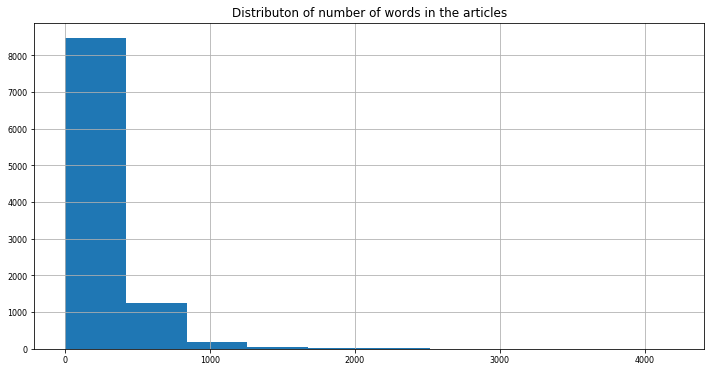

In [18]:
a['length'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the articles")

In [19]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu",
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

In [20]:
data_lemmatized = list(a['clean_text'])

In [21]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=1, no_above=0.4)

# Create Corpus
texts = texts

In [23]:
corpus = [id2word.doc2bow(text) for text in texts]

In [24]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 54614
Number of documents: 10000


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """ 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num_topics, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num_topics,
                                                   per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=25, step=1)

-3.173524431082064
-2.6683915049814244
-3.172395100429835
-2.9992364385338472
-2.547630280730052
-2.9430952617438657
-3.096857906840496
-3.2179017895115356
-3.2630678915443423
-2.9303492133231814
-3.0323198316311815
-3.3799663029229756
-2.7829277434846236
-3.1695029306738762
-3.6502456928705693


'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

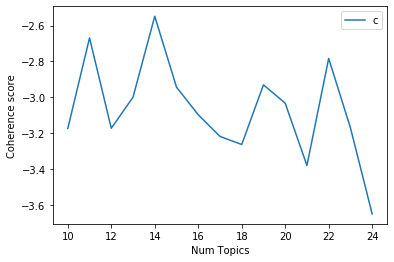

In [27]:
# Show graph
limit=25; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
num=18
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num,
                                                   per_word_topics=True)

In [32]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=18, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.117*"slide" + 0.101*"earn" + 0.100*"articl" + 0.100*"purchas" + 0.100*"recommend" + 0.100*"commiss" + 0.100*"microsoft" + 0.100*"affili" + 0.092*"link" + 0.018*"shutterstock" + 0.004*"courtesi" + 0.002*"googl" + 0.002*"bank" + 0.002*"istock" + 0.001*"egg" + 0.001*"invest" + 0.001*"usa" + 0.001*"lewi" + 0.001*"richard" + 0.001*"mari"

1: 0.018*"charg" + 0.014*"court" + 0.013*"case" + 0.012*"prosecutor" + 0.011*"phone" + 0.011*"time" + 0.011*"feder" + 0.011*"record" + 0.009*"face" + 0.009*"allegedli" + 0.009*"releas" + 0.009*"alleg" + 0.009*"agent" + 0.008*"judg" + 0.008*"accus" + 0.008*"result" + 0.008*"prison" + 0.008*"order" + 0.008*"lie" + 0.007*"enter"

2: 0.079*"water" + 0.048*"beach" + 0.041*"appl" + 0.039*"ship" + 0.035*"feet" + 0.027*"sea" + 0.027*"burn" + 0.020*"disney" + 0.019*"edg" + 0.016*"beyonc" + 0.016*"winter" + 0.016*"japan" + 0.014*"heat" + 0.014*"centuri" + 0.014*"resolut" + 0.013*"vessel" + 0.012*"diamond" + 0.011*"tune" + 0.010*"skin" + 0.010*"gulf"

3: 0.178*"

In [52]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.070957  0.496860       1        1  21.586132
6      0.202720 -0.014923       2        1  15.144488
10     0.213732 -0.016094       3        1  14.433563
17     0.201864 -0.037731       4        1   7.785585
14     0.096089 -0.021795       5        1   5.777644
1      0.095111 -0.019362       6        1   4.953586
12     0.112280 -0.015663       7        1   4.933275
4      0.056264  0.022470       8        1   4.809689
5      0.137893 -0.018886       9        1   4.748137
11     0.177855 -0.050712      10        1   4.315471
7     -0.023618  0.024093      11        1   3.074067
15     0.064610 -0.055431      12        1   2.671196
16    -0.114344  0.002283      13        1   2.034675
13    -0.182407 -0.043708      14        1   1.191333
3     -0.219346 -0.048876      15        1   0.938807
2     -0.221271 -0.054414      16        1   0.741977
9     -0.255816 -0.068624      17        1   0.513941
8     -0.270659 -0.079487      18        1   0.346436, topic_info=           Term          Freq         Total Category  logprob  loglift
708       slide  55053.000000  55053.000000  Default  30.0000  30.0000
687        earn  47482.000000  47482.000000  Default  29.0000  29.0000
703     purchas  47250.000000  47250.000000  Default  28.0000  28.0000
631   recommend  47036.000000  47036.000000  Default  27.0000  27.0000
680     commiss  46981.000000  46981.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1327       hair    425.424072    907.666992  Topic18  -2.8770   4.9074
1333        oil    242.859940    562.627808  Topic18  -3.4376   4.8251
1688       spin     59.661377    160.548340  Topic18  -4.8414   4.6753
1297      brush     36.842884     98.359116  Topic18  -5.3235   4.6833
2973      fresh     47.658867    376.817322  Topic18  -5.0661   3.5975

[999 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1699      7  0.070572       abc
1699      8  0.928999       abc
2738      9  0.998986     abort
2822      6  0.997391   absolut
1017     10  0.985023  accommod
...     ...       ...       ...
2609      3  0.997475   younger
2868     10  0.987443     youth
3936      1  0.389105    youtub
3936      2  0.609429    youtub
2398      4  0.995567       zip

[2162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 11, 18, 15, 2, 13, 5, 6, 12, 8, 16, 17, 14, 4, 3, 10, 9])

In [45]:
l=[]
for i in range(10000):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [46]:
l

[(6, 0.5553751),
 (14, 0.3669466),
 (6, 0.6390491),
 (10, 0.6490546),
 (16, 0.35913768),
 (16, 0.40362638),
 (17, 0.73911285),
 (15, 0.4370401),
 (0, 0.86357296),
 (15, 0.68296087),
 (7, 0.44094533),
 (15, 0.25890437),
 (6, 0.7802723),
 (15, 0.34275842),
 (12, 0.72350967),
 (7, 0.43727213),
 (0, 0.71380496),
 (14, 0.73382825),
 (8, 0.336846),
 (2, 0.43111858),
 (14, 0.36800015),
 (5, 0.42359763),
 (10, 0.58511764),
 (11, 0.51140094),
 (4, 0.8688376),
 (0, 0.913032),
 (10, 0.82625943),
 (17, 0.25348467),
 (5, 0.2891019),
 (0, 0.785361),
 (16, 0.46334872),
 (7, 0.2760522),
 (6, 0.7866516),
 (5, 0.63117594),
 (16, 0.4911966),
 (10, 0.3175936),
 (6, 0.4293033),
 (7, 0.4707084),
 (15, 0.51441485),
 (17, 0.8041689),
 (0, 0.9989883),
 (5, 0.43555233),
 (1, 0.43494496),
 (16, 0.29992905),
 (10, 0.69773304),
 (10, 0.7894602),
 (12, 0.2419514),
 (6, 0.6070856),
 (5, 0.95932764),
 (1, 0.70795494),
 (5, 0.5286209),
 (16, 0.84485346),
 (0, 0.9437033),
 (7, 0.39474478),
 (1, 0.5992164),
 (16, 0.4633

usage of LDA is when you have no labels, and you want to identify which documents are semantically similar to each other, without necessarily determining what the correct class label for the documents is.

In [49]:
a["topic_prob"]= l

In [50]:
a

,level_0,index,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length,topic_prob
0,0,109930,Why USWNT star Megan Rapinoe doesn't sing the ...,Megan Rapinoe during the national anthem befor...,[Henry Bushnell],[https://s.yimg.com/cv/apiv2/default/images/Re...,None,en,[],GER_2019-06-14_9446_web_page.html,www.yahoo.com/sports/megan-rapinoe-national-an...,NaN,us,2.0,5.0,"[megan, rapino, nation, anthem, unit, women, n...",270,"(6, 0.5553751)"
1,1,43993,Narcos season 4 release date: Will there be an...,Narcos season four is called Narcos: Mexico an...,"[Reiss Smith, Narcos Showrunner Eric Newman]",[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/ZsL4voedcJU],en,[],GER_2019-04-22_110664_web_page.html,www.express.co.uk/showbiz/tv-radio/854162/Narc...,NaN,us,1.0,1.0,"[narco, season, narco, mexico, releas, today, ...",346,"(14, 0.3669466)"
2,2,5601,"It’s like Carfax, but free Vehicle History off...",One of the biggest issues with buying a used c...,[Andrew Hard],[https://s.yimg.com/ny/api/res/1.2/JRboVo.Ns6Y...,None,en,[],GER_2019-04-12_95792_web_page.html,www.yahoo.com/news/carfax-free-vehicle-history...,NaN,us,1.0,1.0,"[biggest, issu, buy, car, fear, unknown, paint...",157,"(6, 0.6390491)"
3,3,76567,Top 40 movies you must have on Blu-ray,Mom of slain man says son hugging cop should n...,None,[https://cbsnews3.cbsistatic.com/hub/i/r/2011/...,None,en,"[, pictures, photos, cbs news photos, cbs news...",GER_2019-05-18_89973_web_page.html,www.cbsnews.com/pictures/top-40-movies-you-mus...,NaN,us,40.0,40.0,"[mom, slay, man, son, hug, cop, misconstru]",7,"(10, 0.6490546)"
4,4,35864,"Rachael Ray Is Back, Whether You Like It or Not",Maybe we all owe Rachael Ray an apology. For a...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-04-07_53686_web_page.html,www.msn.com/en-us/foodanddrink/foodnews/rachae...,NaN,us,6.0,6.0,"[owe, rachael, ray, apolog, decad, fashion, ri...",190,"(16, 0.35913768)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,68111,'Grey's Anatomy' will continue for at least 2 ...,(CNN) The doctors at Grey Sloan Memorial Hospi...,[Sandra Gonzalez],[http://pixel.quantserve.com/pixel/p-D1yc5zQgj...,None,None,"[entertainment, 'Grey's Anatomy' will continue...",GER_2019-05-11_13687_web_page.html,www.cnn.com/2019/05/10/entertainment/greys-ana...,NaN,us,1.0,1.0,"[cnn, doctor, grey, sloan, memori, hospit, ret...",52,"(16, 0.28675184)"
9996,9996,84334,Legal Battle Over Civil War-Era Gold Certifica...,(Newser) – A story out of New Jersey has both ...,[Jenn Gidman],[http://img1-azrcdn.newser.com/image/1261438-0...,None,None,"[Elaine Palmer, Lisa Linder, Asbury Park, New ...",GER_2019-05-24_49428_web_page.html,www.newser.com/story/275604/she-sold-her-famil...,NaN,us,1.0,1.0,"[newser, stori, jersey, legal, expert, reddit,...",140,"(14, 0.22318204)"
9997,9997,33349,Dem lawmaker sends Trump 'memo' of things that...,Rep. Ted Lieu Ted W. LieuCities are the future...,None,[http://pixel.quantserve.com/pixel/p-51dZx4IkA...,None,None,"[, Donald Trump, Ted Lieu, ]",GER_2019-04-05_33869_web_page.html,thehill.com/homenews/house/437634-dem-lawmaker...,NaN,us,1.0,1.0,"[rep, ted, lieu, ted, lieuciti, futur, coordin...",152,"(10, 0.26236412)"
9998,9998,84111,The 20 most popular movies from Netflix and ot...,1/21 SLIDES © Netflix Microsoft may earn an Af...,None,[https://linkmaker.itunes.apple.com/assets/sha...,None,en,[],GER_2019-05-24_41051_web_page.html,www.msn.com/en-us/movies/gallery/the-20-most-p...,NaN,us,50.0,50.0,"[slide, netflix, microsoft, earn, affili, comm...",245,"(0, 0.90431076)"


In [51]:
# Number of Documents for Each Topic
topi = a['topic_prob'].apply(lambda x: x[0])
topic_counts=topi.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Num_Documents,Perc_Documents
10,2671,0.2671
6,2375,0.2375
0,1433,0.1433
12,680,0.0680
17,668,0.0668
5,436,0.0436
14,361,0.0361
4,325,0.0325
11,287,0.0287
1,245,0.0245
